In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import os

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from sklearn.metrics import f1_score
import cv2


### Loading Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train-20241026T054920Z-001.zip

Archive:  /content/drive/MyDrive/train-20241026T054920Z-001.zip
   creating: train-20241026T054920Z-001/
   creating: train-20241026T054920Z-001/train/
   creating: train-20241026T054920Z-001/train/Closed/
  inflating: train-20241026T054920Z-001/train/Closed/door0000001.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000002.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000003.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000004.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000005.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000006.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000007.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000008.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000009.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000010.png  
  inflating: train-20241026T054920Z-001/train/Closed/door0000011.png  
  inflating: 

In [ ]:
directory="/content/train-20241026T054920Z-001/train"

In [ ]:
labels = os.listdir(directory)
labels

['Semi', 'Open', 'Closed']

#### Creating Dataframe

In [ ]:
def read_data(folder):
    data, label, paths = [], [], []
    for l in labels:
        path = f"{folder}/{l}/"
        folder_data = os.listdir(path)
        for image_path in folder_data:
            img = cv2.imread(path + image_path)
            data.append(img)
            label.append(l)
            paths.append(os.path.join(directory, l, image_path))

    return data, label, paths

In [ ]:
all_data, all_labels, all_paths = read_data(directory)

In [ ]:
df = pd.DataFrame({
    'image':all_data,
    'path': all_paths,
    'label': all_labels
})

> Split into train, test, and valid sets

In [ ]:
train_df, dummy_df=train_test_split(df, train_size=.8, random_state=123, shuffle=True, stratify=df['label'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, random_state=123, shuffle=True, stratify=dummy_df['label'])
print("Train dataset : ",len(train_df),"Test dataset : ",len(test_df),"Validation dataset : ",len(valid_df))
train_balance=train_df['label'].value_counts()
print('Train dataset value count: \n',train_df['label'].value_counts())

Train dataset :  916 Test dataset :  115 Validation dataset :  115
Train dataset value count: 
 label
Open      454
Closed    358
Semi      104
Name: count, dtype: int64


In [ ]:
import plotly.express as px

In [ ]:
px.histogram(train_df, x='label', barmode='group')

> Value counts of all the different labels in train set

### Data Augmentation

In [ ]:
import cv2
import numpy as np

In [ ]:
def apply_transform(image):

    # Rotate (random angle between -40 and 40 degrees)
    angle = np.random.uniform(-40, 40)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))

    # Horizontal Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)

    # Vertical Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)

    # Random Brightness and Contrast
    alpha = 1.0 + np.random.uniform(-0.2, 0.2)  # Brightness
    beta = 0.0 + np.random.uniform(-0.2, 0.2)   # Contrast
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Random Gamma Correction
    gamma = np.random.uniform(0.8, 1.2)
    image = np.clip((image / 255.0) ** gamma, 0, 1) * 255.0

    return image

In [ ]:
def apply_augmentation(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented_image = apply_transform(image=image)
    return augmented_image, label

In [ ]:
augmented_data = []
for index, row in train_df.iterrows():
    image_path = row['path']
    label = row['label']
    augmented_image, augmented_label = apply_augmentation(image_path, label)
    augmented_data.append((augmented_image, augmented_label, image_path))

In [ ]:
augmented_df = pd.DataFrame(augmented_data, columns=['object', 'label', 'path'])

In [ ]:
merged_df = pd.concat([train_df, augmented_df], ignore_index=True)

In [ ]:
from collections import Counter

In [ ]:
class_counts = Counter(merged_df['label'])
min_class_count = min(class_counts.values())

balanced_data = []
for label, count in class_counts.items():
    class_samples = merged_df[merged_df['label'] == label].sample(min_class_count)
    balanced_data.append(class_samples)

balanced_df = pd.concat(balanced_data)

In [ ]:
balanced_df['label'].value_counts()

,count
label,
Open,208
Closed,208
Semi,208


In [ ]:
gen=ImageDataGenerator()

In [ ]:
train_gen=gen.flow_from_dataframe(balanced_df, x_col='path', y_col='label', target_size=(128,128),seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=5)

Found 624 validated image filenames belonging to 3 classes.


In [ ]:
val_gen=gen.flow_from_dataframe(valid_df, x_col='path', y_col='label', target_size=(128,128),seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=5)

Found 115 validated image filenames belonging to 3 classes.


In [ ]:
test_gen=gen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=(128,128),seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=5)

Found 115 validated image filenames belonging to 3 classes.


In [ ]:
!pip install bottleneck


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from tensorflow import keras
import keras
from keras import layers
import tensorflow as tf
import numpy.matlib
from PIL import Image
from keras import backend as K
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import bottleneck

In [ ]:
class Bottleneck(keras.Model):
  def __init__(
      self,
      expansion,
      stride,
      block_id,
      filters,
      alpha=2,
      ):
    super(Bottleneck,self).__init__(name = "Bottleneck_" + block_id)
    self.stride = stride
    self.expansion = expansion
    self.alpha = alpha
    self.output_channels = self.alpha * filters
    self.out = None # there was some problem with the eager execution

    prefix =  'Bottleneck_{}_'.format(block_id)
    self.prefix = prefix
    # expansion
    self.expand_BN = layers.BatchNormalization(name = prefix + 'expand_BN')
    self.expand_ReLU = layers.ReLU(max_value=6, name = prefix + 'expand_ReLU')

    #conv
    self.Conv = layers.DepthwiseConv2D(
        kernel_size = 3,
        padding='same',
        strides = self.stride,
        use_bias = False,
        name = prefix + 'conv')
    self.Conv_BN = layers.BatchNormalization(name = prefix + 'conv_BN')
    self.Conv_ReLU = layers.ReLU(max_value=6, name = prefix + 'conv_ReLU')
    #conv2d
    self.conv2d = layers.Conv2D(
        filters = self.output_channels,
        padding= 'same',
        kernel_size = 3,
        use_bias = False,
        name = prefix +'conv_2d')
    self.conv2d_BN = layers.BatchNormalization(name = prefix + 'conv_BN')
    self.conv2d_ReLU = layers.ReLU(max_value=6, name = prefix + 'conv_ReLU')
    #project
    self.project = layers.Conv2D(
        filters = self.output_channels,
        kernel_size = 1,
        use_bias = False,
        name = 'contract')
    self.project_BN = layers.BatchNormalization(name = prefix + 'contract_BN')

    # dimensions need to be the same for residual connection
    self.residual = layers.Add(name=prefix + 'residual')



  def build(self, input_shape):
    self.d = input_shape[-1]

    self.expand = layers.Conv2D(
        filters = self.expansion*self.d,
        kernel_size = 1,
        use_bias = False,
        name = self.prefix+'expand')


  def call(self, inputs):

    x = self.expand(inputs)
    x = self.expand_BN(x)
    x = self.expand_ReLU(x)
    self.out = x
    x = self.Conv(x)
    x = self.Conv_BN(x)
    x = self.Conv_ReLU(x)
    x = self.project(x)
    x = self.project_BN(x)
    if x.shape[-1] == inputs.shape[-1]:
      x = self.residual([inputs,x])
    x =  self.conv2d(x)
    x = self.conv2d_BN(x)
    x = self.conv2d_ReLU(x)
    if x.shape[-1] == inputs.shape[-1]:
      x = self.residual([inputs,x])


    return x

  def model(self):
      x = keras.Input()
      return keras.Model(inputs=[x], outputs=self.call(x))

In [ ]:

class TypicalNet(keras.Model):
    def __init__(self, k=3, filtering_mode=False):
        super(TypicalNet, self).__init__()
        self.filtering_mode = filtering_mode
        self.conv_inp = layers.Conv2D(
            filters=128, kernel_size=3, strides=1, padding='valid', use_bias=False, name='conv'
        )
        self.k = k
        self.BN = layers.BatchNormalization(name='BN')
        self.ReLU = layers.ReLU(max_value=6, name='ReLU')
        self.expansion = 2
        self.i =64
        self.prefix = 'block_'

        self.B1_1 = Bottleneck(expansion=2, filters=64, stride=1, block_id='B1_1')
        self.B1_2 = Bottleneck(expansion=2, filters=64, stride=1, block_id='B1_2')

        self.B2_1 = Bottleneck(expansion=2, filters=128, stride=1, block_id='B2_1')
        self.B2_2 = Bottleneck(expansion=2, filters=128, stride=1, block_id='B2_2')
        self.B2_3 = Bottleneck(expansion=2, filters=128, stride=1, block_id='B2_3')

        self.B3_1 = Bottleneck(expansion=2, filters=256, stride=1, block_id='B3_1')
        self.B3_2 = Bottleneck(expansion=2, filters=256, stride=1, block_id='B3_2')
        self.B3_3 = Bottleneck(expansion=2, filters=256, stride=1, block_id='B3_3')

        self.B4_1 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B4_1')
        self.B4_2 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B4_2')
        self.B4_3 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B4_3')
        self.B4_4 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B4_4')

        self.B5_1 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B5_1')
        self.B5_2 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B5_2')
        self.B5_3 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B5_3')
        self.B5_4 = Bottleneck(expansion=2, filters=512, stride=1, block_id='B5_4')



        self.expand = layers.Conv2D(
        filters = self.expansion*self.i,
        kernel_size = 1,
        use_bias = False,
        name = self.prefix+'expand')

        self.expand_BN = layers.BatchNormalization(name = self.prefix + 'expand_BN')
        self.expand_ReLU = layers.ReLU(max_value=6, name = self.prefix + 'expand_ReLU')


        self.conv_out = layers.Conv2D(filters=1280, kernel_size=1, strides=(1,1), use_bias=False, name='conv_out')
        self.avgpool = layers.AveragePooling2D(pool_size=(7,7), name='avg_pool')


        self.flatten = layers.Flatten(name="flatten")
        self.dense = layers.Dense(units=self.k, activation='softmax', name="output_dense")


        self.conv_seg = layers.Conv2D(filters=self.k, kernel_size=1, strides=(1,1), use_bias=False, name='conv_seg')


    def call(self, inputs):
        x = self.conv_inp(inputs)
        x = self.BN(x)
        x = self.ReLU(x)
        x = self.B1_1(x)
        x = self.B1_2(x)


        if self.filtering_mode:
            self.out_b1 = x


        x = self.B2_1(x)
        x = self.B2_2(x)
        x = self.B2_3(x)
        if self.filtering_mode:
            self.out_b2 = x
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

        x = self.B3_1(x)
        x = self.B3_2(x)
        x = self.B3_3(x)
        if self.filtering_mode:
            self.out_b3 = x


        x = self.B4_1(x)
        x = self.B4_2(x)
        x = self.B4_3(x)
        x = self.B4_4(x)
        if self.filtering_mode:
            self.out_b4 = x
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

        x = self.B5_1(x)
        x = self.B5_2(x)
        x = self.B5_3(x)
        x = self.B5_4(x)

        x = self.conv_out(x)
        x = self.avgpool(x)

        if self.filtering_mode:
            self.final_feature = x

        x = self.flatten(x)
        c4 = self.dense(x)

        return c4



    def model(self):
        x = keras.Input(shape=(128, 128, 3))
        return keras.Model(inputs=x, outputs=self.call(x))



In [ ]:
model = TypicalNet(3,False)
model.build(input_shape=(None, 128, 128, 3))
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

TypicalNet().model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv (Conv2D)               (None, 126, 126, 128)     3456      
                                                                 
 BN (BatchNormalization)     (None, 126, 126, 128)     512       
                                                                 
 ReLU (ReLU)                 (None, 126, 126, 128)     0         
                                                                 
 Bottleneck_B1_1 (Bottlenec  (None, 126, 126, 128)     218368    
 k)                                                              
                                                                 
 Bottleneck_B1_2 (Bottlenec  (None, 126, 126, 128)     218368    
 k)                                                          

> CNN model is giving very low validation accuracy


In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"


In [ ]:
rlronp=keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4, patience=2, verbose=1, mode="auto",  min_delta=0.00001, cooldown=0, min_lr=0.0)
estop=keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,  patience=2, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
callbacks=[rlronp, estop]

In [31]:
history=model.fit(x=train_gen,   epochs=10, verbose=1, callbacks=callbacks,  validation_data=val_gen,
                   validation_steps=None,  shuffle=True)

Epoch 1/10
125/125 [==============================] - 1488s 12s/step - loss: 11.1866 - accuracy: 0.4391 - val_loss: 4.4326 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 1473s 12s/step - loss: 2.2891 - accuracy: 0.6378 - val_loss: 1.6523 - val_accuracy: 0.1130 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 1479s 12s/step - loss: 1.4030 - accuracy: 0.6779 - val_loss: 1.2469 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 1476s 12s/step - loss: 1.0419 - accuracy: 0.7228 - val_loss: 1.5841 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.7901 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Restoring model weights from the end of the best epoch: 3.
125/125 [==============================] - 1480s 12s/step - loss: 0.6831 - accuracy: 0.7901 - val_loss: 1.9066 - val_accuracy: 0.4696 -

In [33]:
import matplotlib.pyplot as plt

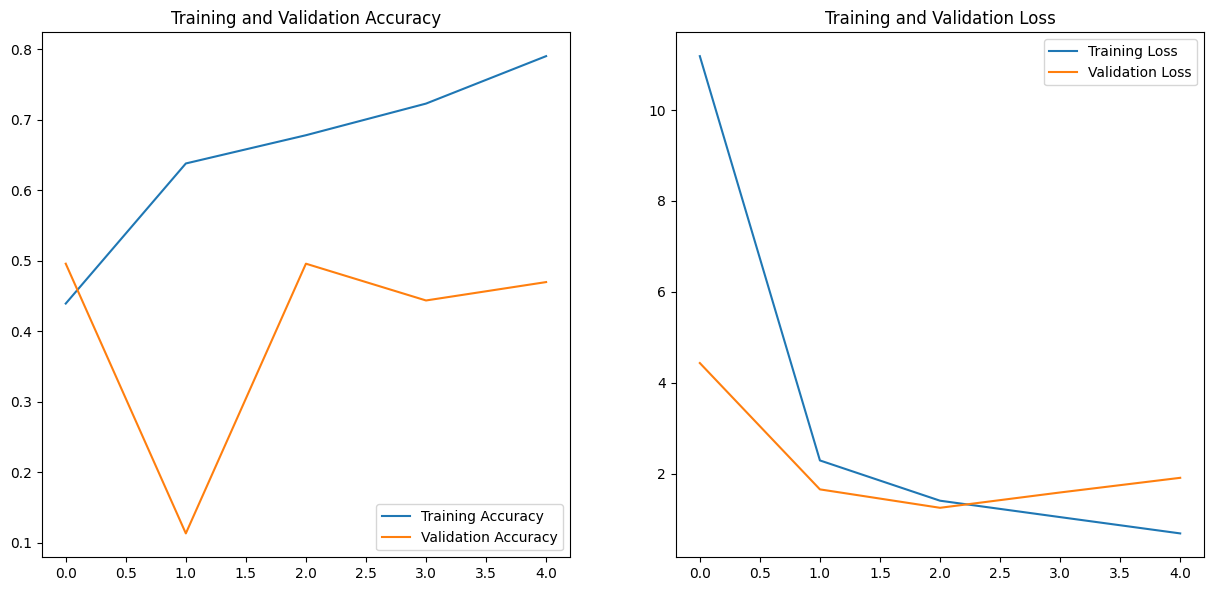

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = acc[:5]
val_acc = val_acc[:5]
loss = loss[:5]
val_loss = val_loss[:5]
epochs_range = range(5)

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Saving Model

In [35]:
model.save("typicalnet",save_format='tf')
print("Saved model to disk")

Saved model to disk
